<a href="https://colab.research.google.com/github/tsakailab/sandbox/blob/master/pytorch_RPCA_with_prox_backward_cuda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
    print(torch.cuda.memory_allocated())
    print(torch.cuda.memory_cached())
    torch.cuda.empty_cache()

Tesla P100-PCIE-16GB
0
0


# L1 and nuclear loss functions with backward by prox (soft thresholding and singular value thresholding)

In [0]:
soft = lambda z, th: z.sign() * (z.abs() - th).max(torch.tensor(0., device=device))

## L1 loss
class L1LossFunc(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, lw):
        ctx.save_for_backward(input, lw)
        return torch.sum(torch.abs(input)*lw)

    @staticmethod
    def backward(ctx, grad_output):
        input, lw = ctx.saved_tensors
        grad_input = grad_output.clone()
        return (input - soft(input, lw)) * grad_input, torch.abs(input) * grad_input

class L1Loss(torch.nn.Module):
    def __init__(self, lw=torch.tensor(1.0, device=device)):
        super(L1Loss, self).__init__()
        self.fn = L1LossFunc.apply
        self.lw = torch.nn.Parameter(lw, requires_grad=lw.requires_grad)

    def forward(self, input):
        return self.fn(input, self.lw)


## Nuclear loss
class NuclearLossFunc(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, lw):
        u, s, v = torch.svd(input)
        ctx.save_for_backward(input, lw, u, s, v)
        return torch.sum(s*lw)

    @staticmethod
    def backward(ctx, grad_output):
        input, lw, u, s, v = ctx.saved_tensors
        grad_input = grad_output.clone()
        svt_input = torch.matmul(torch.matmul(u, torch.diag_embed(soft(s,lw))), torch.transpose(v, -2, -1))
        return (input - svt_input) * grad_input, s * grad_input

class NuclearLoss(torch.nn.Module):
    def __init__(self, lw=torch.tensor(1.0, device=device)):
        super(NuclearLoss, self).__init__()
        self.fn = NuclearLossFunc.apply
        self.lw = torch.nn.Parameter(lw, requires_grad=lw.requires_grad)

    def forward(self, input):
        return self.fn(input, self.lw)


# Robust PCA (Low-rank and sparse matrix approximation): $$\textrm{Minimize}_{(L,S)}\|L\|_* + \lambda_S \|S\|_1+\lambda_F\|D-(L+S)\|_F^2$$
### Auto differentiation vs. proximal operation



In [3]:
# generate a low-rank matrix L and a sparse matrix S
from time import time
import numpy as np
m, n = 10, 5 #3,5
rnk, nnz = 2,8#8, 30 # 2,2
LL = np.random.randn(m,rnk).dot(np.random.randn(rnk,n))
SS = np.zeros((m,n))
support = np.random.choice(m*n, nnz, replace=False)
SS.ravel()[support] = 10.* np.random.randn(support.size)

sv = np.linalg.svd(LL, compute_uv=False)
print('singular values of L =')
print(sv[:min(10,m,n)])
print('mean(abs(L)) = %.2e' % (np.mean(np.abs(LL))))
print('mean(abs(S)) = %.2e, %d nonzeros in S (%2.1f%%)' % (np.mean(np.abs(SS)),support.size,100.*support.size/(m*n)))

DD = LL + SS

ll = 1./np.sqrt(max(m,n))
print('lambda_S = ', ll)

singular values of L =
[8.16145386e+00 5.47708278e+00 1.08304198e-15 6.70736780e-16
 2.11566845e-16]
mean(abs(L)) = 1.10e+00
mean(abs(S)) = 1.43e+00, 8 nonzeros in S (16.0%)
lambda_S =  0.31622776601683794


D = 
 tensor([[ -0.7894,  -2.1138,   0.4986,  -0.9767,   0.9865],
        [  1.1721,  16.1810,  -0.7603,   1.2075,  -1.4528],
        [ -5.0651,   0.1592,   0.6137,   1.1421,   0.7866],
        [  0.6127,   0.1807,  -0.5051,  -2.6952,  -0.6957],
        [-16.5924,  -2.1946,  -1.1828,  -1.1055,  -1.7160],
        [  1.4713,   1.4309,  -1.1322,  -0.6427,  -1.7183],
        [ -1.2904,  -0.4048,   1.0617,   1.3984,   4.4035],
        [  0.8101,   4.7657, -14.5142,  17.0315,  -1.1366],
        [  0.2562,   0.6061,  -0.1683,   0.2385,  -0.3163],
        [ -0.4158,   1.6836,   0.4889,   2.2317,   0.3856]], device='cuda:0')
lambda_F =  1000000.0
[  3/60]: loss = 60.7711,  
[  6/60]: loss = 56.9265,  
[  9/60]: loss = 53.5905,  
[ 12/60]: loss = 50.5213,  
[ 15/60]: loss = 47.5686,  
[ 18/60]: loss = 44.9269,  
[ 21/60]: loss = 42.6454,  
[ 24/60]: loss = 40.6946,  
[ 27/60]: loss = 39.0291,  
[ 30/60]: loss = 37.6458,  
[ 33/60]: loss = 36.6721,  
[ 36/60]: loss = 35.8692,  
[ 39/60]: loss = 3

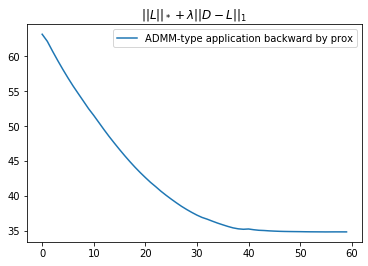

In [4]:
# ADMM-type (Inexact ALM) application of backward by prox

D = torch.from_numpy(DD.astype(np.float32)).to(device)
print('D = \n', D)

le = 1e+6
print('lambda_F = ', le)

# Using L1Loss with prox
nucloss = NuclearLoss()
l1loss = L1Loss(lw=torch.tensor(ll))
l2loss = lambda x: torch.sum(x**2)

L = 0
S = 0
E = 0
Y = 0

t = time()
num_iter = 60
display_step = 3
history_loss_inexact = []
for iter in range(num_iter):
    total_loss = 0.

    X = (D-S-E+Y).clone().detach().requires_grad_(True)
    loss = nucloss(X)
    optimizer = torch.optim.SGD([X], lr = 1e0)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    L = X.detach()

    X = (D-L-E+Y).clone().detach().requires_grad_(True)
    loss = l1loss(X)
    optimizer = torch.optim.SGD([X], lr = 1e0)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    S = X.detach()

    X = ((D-L-S+Y)/ (1+2*le)).clone().detach().requires_grad_(True)
    loss = l2loss(X)
    optimizer = torch.optim.SGD([X], lr = 1e0)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    E = X.detach()

    Y = Y + (D-L-S-E)

    total_loss = nucloss(L) + l1loss(D-L)

    history_loss_inexact.append(total_loss)

    if (iter+1) % display_step == 0:
        print ('[{:3d}/{}]: loss = {:.4f},  '.format(iter+1, num_iter, total_loss))

print((time()-t)*1000, ' [ms]')
print('L = \n', LL)
print('Estimated L = \n', L.data)
print(torch.norm(L-torch.tensor(LL).to(device))/np.linalg.norm(LL,'fro'))
print('Its singular values = \n', torch.svd(L)[1])
print('S = \n', SS)
print('Estimated S = \n', S.data)
print(torch.norm(S-torch.tensor(SS).to(device))/np.linalg.norm(SS))

import matplotlib.pyplot as plt
plt.title("$||L||_*+\lambda||D-L||_1$")
plt.plot(history_loss_inexact, label="ADMM-type application backward by prox")
plt.legend()


### Robust PCA: $$\textrm{Minimize}_{L}\|L\|_* + \lambda \|D-L\|_1$$
### using auto differentiation


D = 
 tensor([[ -0.7894,  -2.1138,   0.4986,  -0.9767,   0.9865],
        [  1.1721,  16.1810,  -0.7603,   1.2075,  -1.4528],
        [ -5.0651,   0.1592,   0.6137,   1.1421,   0.7866],
        [  0.6127,   0.1807,  -0.5051,  -2.6952,  -0.6957],
        [-16.5924,  -2.1946,  -1.1828,  -1.1055,  -1.7160],
        [  1.4713,   1.4309,  -1.1322,  -0.6427,  -1.7183],
        [ -1.2904,  -0.4048,   1.0617,   1.3984,   4.4035],
        [  0.8101,   4.7657, -14.5142,  17.0315,  -1.1366],
        [  0.2562,   0.6061,  -0.1683,   0.2385,  -0.3163],
        [ -0.4158,   1.6836,   0.4889,   2.2317,   0.3856]], device='cuda:0')
[  3/60]: loss = 61.6647,  
[  6/60]: loss = 57.8204,  
[  9/60]: loss = 54.5575,  
[ 12/60]: loss = 51.4696,  
[ 15/60]: loss = 48.5217,  
[ 18/60]: loss = 45.7739,  
[ 21/60]: loss = 43.2901,  
[ 24/60]: loss = 41.2441,  
[ 27/60]: loss = 39.5604,  
[ 30/60]: loss = 38.3700,  
[ 33/60]: loss = 37.4501,  
[ 36/60]: loss = 36.7855,  
[ 39/60]: loss = 36.3760,  
[ 42/60]: lo

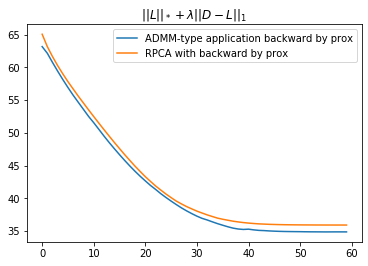

In [5]:
# Alternating-projection-like application of backward by prox

D = torch.from_numpy(DD.astype(np.float32)).to(device)
print('D = \n', D)

# Using L1Loss with prox
nucloss = NuclearLoss()
l1loss = L1Loss(lw=torch.tensor(ll))
#X = torch.autograd.Variable(D, requires_grad=True)
L = torch.tensor(DD.astype(np.float32), device=device, requires_grad=True)
optimizer = torch.optim.SGD([L], lr = 1e0)

t = time()
num_iter = 60
display_step = 3
history_loss_prox = []
for iter in range(num_iter):
    total_loss = 0.
    #"""
    loss = nucloss(L) + l1loss(D - L)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    total_loss += loss.item()
    """
    loss = nucloss(L)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    total_loss += loss.item()

    loss = l1loss(D - L)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    total_loss += loss.item()
    """

    history_loss_prox.append(total_loss)

    if (iter+1) % display_step == 0:
        print ('[{:3d}/{}]: loss = {:.4f},  '.format(iter+1, num_iter, total_loss))


print((time()-t)*1000, ' [ms]')
print('L = \n', LL)
print('Estimated L = \n',L.data)
print(torch.norm(X-torch.tensor(LL).to(device))/np.linalg.norm(LL,'fro'))
print('Its singular values = \n', torch.svd(L)[1])
print('S = \n', SS)
print('Estimated S = \n', D-L)
print(torch.norm((D-L)-torch.tensor(SS).to(device))/np.linalg.norm(SS))

import matplotlib.pyplot as plt
plt.title("$||L||_*+\lambda||D-L||_1$")
plt.plot(history_loss_inexact, label="ADMM-type application backward by prox")
plt.plot(history_loss_prox, label="RPCA with backward by prox")
#plt.plot(history_loss_prox, label="Alternating-projection-like application of backward by prox")
plt.legend()


D = 
 tensor([[ -0.7894,  -2.1138,   0.4986,  -0.9767,   0.9865],
        [  1.1721,  16.1810,  -0.7603,   1.2075,  -1.4528],
        [ -5.0651,   0.1592,   0.6137,   1.1421,   0.7866],
        [  0.6127,   0.1807,  -0.5051,  -2.6952,  -0.6957],
        [-16.5924,  -2.1946,  -1.1828,  -1.1055,  -1.7160],
        [  1.4713,   1.4309,  -1.1322,  -0.6427,  -1.7183],
        [ -1.2904,  -0.4048,   1.0617,   1.3984,   4.4035],
        [  0.8101,   4.7657, -14.5142,  17.0315,  -1.1366],
        [  0.2562,   0.6061,  -0.1683,   0.2385,  -0.3163],
        [ -0.4158,   1.6836,   0.4889,   2.2317,   0.3856]], device='cuda:0')
lambda = 
 0.31622776601683794
[  3/60]: loss = 65.7144,  
[  6/60]: loss = 58.9324,  
[  9/60]: loss = 51.5432,  
[ 12/60]: loss = 47.1709,  
[ 15/60]: loss = 42.9551,  
[ 18/60]: loss = 40.6166,  
[ 21/60]: loss = 39.0899,  
[ 24/60]: loss = 37.9905,  
[ 27/60]: loss = 38.0584,  
[ 30/60]: loss = 37.8805,  
[ 33/60]: loss = 37.6812,  
[ 36/60]: loss = 37.5305,  
[ 39/60]:

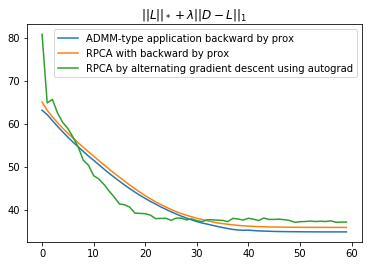

In [6]:
# RPCA with alternating gradient descent using autograd

D = torch.from_numpy(DD.astype(np.float32)).to(device)
print('D = \n', D)

ll = 1./np.sqrt(max(m,n))
print('lambda = \n', ll)

nucloss = lambda x: torch.sum(torch.svd(x)[1])
l1loss = lambda x: torch.sum(torch.abs(x)*ll)

L = torch.tensor(DD.astype(np.float32), device=device, requires_grad=True)
optimizer = torch.optim.Adam([L], lr = 1e0)

t = time()
num_iter = 60
display_step = 3
history_loss = []
for iter in range(num_iter):
    total_loss = 0.
    """
    loss = nucloss(L) + l1loss(D-L)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    total_loss += loss.item()
    """
    loss = nucloss(L)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    total_loss += loss.item()

    loss = l1loss(D-L)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    total_loss += loss.item()
    #"""

    #total_loss = nucloss(L) + l1loss(D-L)
    history_loss.append(total_loss)

    if (iter+1) % display_step == 0:
        print ('[{:3d}/{}]: loss = {:.4f},  '.format(iter+1, num_iter, total_loss))


print((time()-t)*1000, ' [ms]')
print('L = \n', LL)
print('Estimated L = \n', L.data)
print(torch.norm(X-torch.tensor(LL).to(device))/np.linalg.norm(LL,'fro'))
print('Its singular values = \n', torch.svd(X)[1])
print('S = \n', SS)
S = D-L
print('Estimated S = \n', S)
print(torch.norm(S-torch.tensor(SS).to(device))/np.linalg.norm(SS))

import matplotlib.pyplot as plt
plt.title("$||L||_*+\lambda||D-L||_1$")
plt.plot(history_loss_inexact, label="ADMM-type application backward by prox")
plt.plot(history_loss_prox, label="RPCA with backward by prox")
plt.plot(history_loss, label="RPCA by alternating gradient descent using autograd")
plt.legend()

In [0]:
# RPCA by gradient descent using autograd

D = torch.from_numpy(DD.astype(np.float32)).to(device)
print('D = \n', D)

ll = 1./np.sqrt(max(m,n))
print('lambda = \n', ll)
le = 1e+6

# Using sum of abs with autogradient
nucloss = lambda x: torch.sum(torch.svd(x)[1])
l1loss = lambda x: torch.sum(torch.abs(x)*ll)
l2loss = lambda x: torch.sum(x**2)

L = torch.tensor(DD.astype(np.float32), device=device, requires_grad=True)
S = torch.zeros_like(D, device=device, requires_grad=True)

t = time()
num_iter = 60
display_step = 3
history_loss = []
for iter in range(num_iter):
    total_loss = 0.
    #"""
    #optimizer = torch.optim.SGD([L,S], lr = 1e0)
    #loss = nucloss(L) + l1loss(S) + l2loss((D-L-S)/(1+2*le))
    optimizer = torch.optim.SGD([L], lr = 1e0)
    loss = nucloss(L) + l1loss(D-L)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    total_loss += loss.item()
    """
    optimizer = torch.optim.SGD([L], lr = 1e-1)
    loss = nucloss(L)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    total_loss += loss.item()

    optimizer = torch.optim.SGD([S], lr = 1e-1)
    loss = l1loss(S)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    total_loss += loss.item()

    optimizer = torch.optim.SGD([L,S], lr = 1e-1)
    loss = l2loss(D-L-S)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    total_loss += loss.item()
    """

    #total_loss = nucloss(L) + l1loss(D-L)
    history_loss.append(total_loss)

    if (iter+1) % display_step == 0:
        print ('[{:3d}/{}]: loss = {:.4f},  '.format(iter+1, num_iter, total_loss))


print((time()-t)*1000, ' [ms]')
print('L = \n', LL)
print('Estimated L = \n', L.data)
print(torch.norm(X-torch.tensor(LL).to(device))/np.linalg.norm(LL,'fro'))
print('Its singular values = \n', torch.svd(X)[1])
print('S = \n', SS)
S = D-L
print('Estimated S = \n', S)
print(torch.norm(S-torch.tensor(SS).to(device))/np.linalg.norm(SS))

import matplotlib.pyplot as plt
plt.title("$||L||_*+\lambda||D-L||_1$")
plt.plot(history_loss_inexact, label="ADMM-type application backward by prox")
plt.plot(history_loss_prox, label="RPCA with backward by prox")
plt.plot(history_loss, label="RPCA by gradient descent using autograd")
plt.legend()